In [1]:
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.use('ggplot')
from fredapi import Fred
from utils.key import APIKEY as API_FRED
import utils_FRED_MD.model_evaluation  as me
from utils_FRED_MD.format_datasets import  get_nonNANs_fullsample

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix ,precision_score, recall_score, f1_score, classification_report ,roc_curve, roc_auc_score ,roc_curve, auc, ConfusionMatrixDisplay , RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as smf

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Para o grafico 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

import utils_FRED_MD.model_evaluation  as me
SPLIT = 0.7
SEED=42
mms = MinMaxScaler()
scaler = StandardScaler()


df = get_nonNANs_fullsample()
df.head()

Columns dropped: 


,date,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST,USREC
0,1959-01-01,2583.560,2426.0,15.188,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,29.6,15.164,63.517,18.294,10.152,2.13,2.45,2.04,84.2043,0.0
1,1959-02-01,2593.596,2434.8,15.346,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,29.6,15.179,63.554,18.302,10.167,2.14,2.46,2.05,83.5280,0.0
2,1959-03-01,2610.396,2452.7,15.491,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,29.6,15.189,63.634,18.289,10.185,2.15,2.45,2.07,81.6405,0.0
3,1959-04-01,2627.446,2470.0,15.435,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,29.6,15.219,63.698,18.300,10.221,2.16,2.47,2.08,81.8099,0.0
4,1959-05-01,2642.720,2486.4,15.622,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,29.6,15.227,63.804,18.280,10.238,2.17,2.48,2.08,80.7315,0.0


In [2]:
X = df.drop(['USREC','date'],axis=1)
y = df['USREC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT, random_state=SEED, stratify=y)



X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)


In [3]:
arvores = [1, 10, 50, 100, 150, 200, 250, 500, 1000, 1500]
train_results = []
test_results = []
for arvore in arvores:
    print(arvore, " -", end =" ")
    rf = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', n_estimators = arvore, n_jobs = 5, oob_score = True, random_state = 42);
    rf.fit(X_train_norm, y_train)
    train_pred = rf.predict(X_train_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

1  - 10  - 50  - 100  - 150  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


200  - 250  - 500  - 1000  - 1500  - 

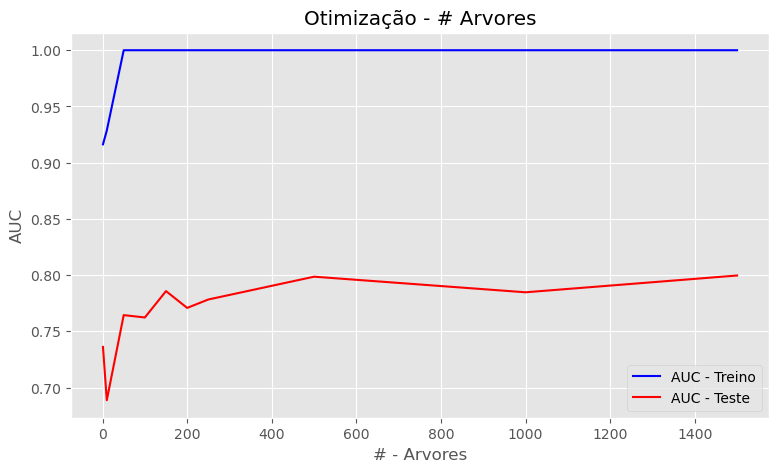

In [4]:
plt.figure(figsize = (9,5))
line1, = plt.plot(arvores, train_results, "b", label = "AUC - Treino")
line2, = plt.plot(arvores, test_results, "r", label = "AUC - Teste")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("AUC")
plt.xlabel("# - Arvores")
plt.legend()
plt.title("Otimização - # Arvores")
plt.show()

In [5]:
max_depths = np.linspace(1, 32, 32, endpoint = True)
train_results = []
test_results = []
for max_depth in max_depths:
    print(max_depth, " -", end =" ")
    rf = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', max_depth = max_depth, n_jobs = 5, oob_score = True, random_state = 42)
    rf.fit(X_train_norm, y_train)
    train_pred = rf.predict(X_train_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

1.0  - 2.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


3.0  - 4.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


5.0  - 6.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


7.0  - 8.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


9.0  - 10.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


11.0  - 12.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


13.0  - 14.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


15.0  - 16.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


17.0  - 18.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


19.0  - 20.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


21.0  - 22.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


23.0  - 24.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


25.0  - 26.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


27.0  - 28.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


29.0  - 30.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


31.0  - 32.0  - 

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


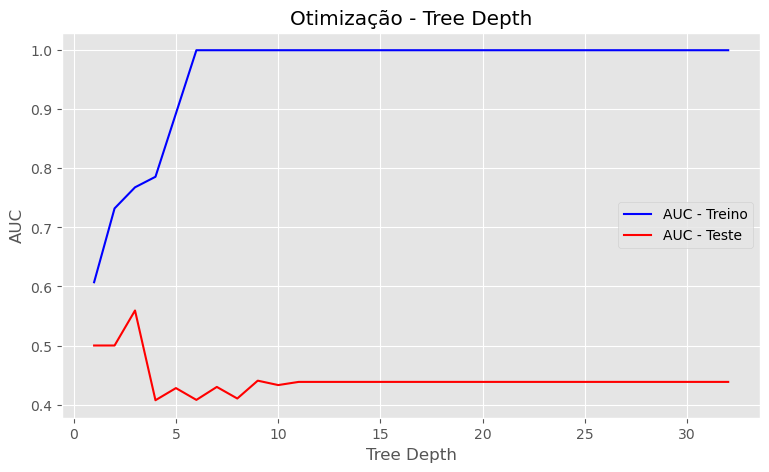

In [6]:
plt.figure(figsize = (9,5))
line1, = plt.plot(max_depths, train_results, "b", label= "AUC - Treino")
line2, = plt.plot(max_depths, test_results, "r", label = "AUC - Teste")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("AUC")
plt.xlabel("Tree Depth")
plt.legend()
plt.title("Otimização - Tree Depth")
plt.show()

In [7]:
min_samples_splits = np.linspace(0.1, 1.0, 25, endpoint = True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    print(min_samples_split, " -", end =" ")
    rf = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', min_samples_split = min_samples_split, n_jobs = 5, oob_score = True, random_state = 42)
    rf.fit(X_train_norm, y_train)
    train_pred = rf.predict(X_train_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

0.1  - 0.1375  - 0.175  - 0.2125  - 0.25  - 0.2875  - 0.32499999999999996  - 0.36250000000000004  - 0.4  - 0.4375  - 0.475  - 0.5125  - 0.5499999999999999  - 0.5875  - 0.625  - 0.6625  - 0.7  - 0.7374999999999999  - 0.7749999999999999  - 0.8125  - 0.85  - 0.8875  - 0.9249999999999999  - 0.9624999999999999  - 1.0  - 

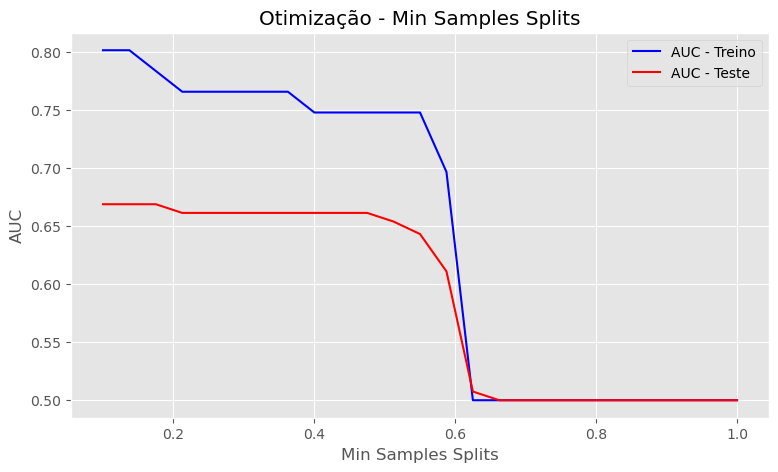

In [8]:
plt.figure(figsize = (9,5))
line1, = plt.plot(min_samples_splits, train_results, "b", label= "AUC - Treino")
line2, = plt.plot(min_samples_splits, test_results, "r", label = "AUC - Teste")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("AUC")
plt.xlabel("Min Samples Splits")
plt.legend()
plt.title("Otimização - Min Samples Splits")
plt.show()

In [23]:
np.linspace(0.1, 0.5, 25, endpoint=True)

array([0.1       , 0.11666667, 0.13333333, 0.15      , 0.16666667,
       0.18333333, 0.2       , 0.21666667, 0.23333333, 0.25      ,
       0.26666667, 0.28333333, 0.3       , 0.31666667, 0.33333333,
       0.35      , 0.36666667, 0.38333333, 0.4       , 0.41666667,
       0.43333333, 0.45      , 0.46666667, 0.48333333, 0.5       ])

In [9]:
min_samples_leafs = np.linspace(0.1, 0.5, 30, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    print(min_samples_leaf, " -", end =" ")
    rf = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', min_samples_leaf = min_samples_leaf, n_jobs = 5, oob_score = True, random_state = 42)
    rf.fit(X_train_norm, y_train)
    train_pred = rf.predict(X_train_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

0.1  - 0.11379310344827587  - 0.12758620689655173  - 0.1413793103448276  - 0.15517241379310345  - 0.16896551724137931  - 0.1827586206896552  - 0.19655172413793104  - 0.21034482758620693  - 0.22413793103448276  - 0.23793103448275865  - 0.25172413793103454  - 0.2655172413793104  - 0.2793103448275862  - 0.2931034482758621  - 0.306896551724138  - 0.3206896551724138  - 0.33448275862068966  - 0.34827586206896555  - 0.36206896551724144  - 0.3758620689655173  - 0.3896551724137931  - 0.403448275862069  - 0.4172413793103449  - 0.4310344827586208  - 0.44482758620689655  - 0.45862068965517244  - 0.47241379310344833  - 0.4862068965517242  - 0.5  - 

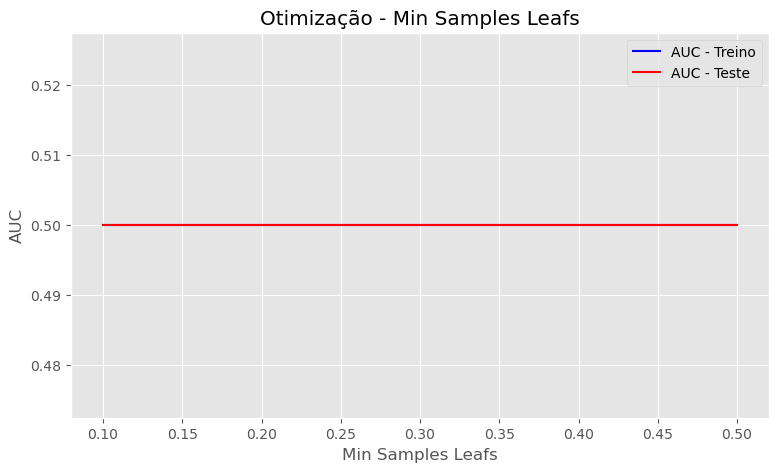

In [10]:
plt.figure(figsize = (9,5))
line1, = plt.plot(min_samples_leafs, train_results, "b", label= "AUC - Treino")
line2, = plt.plot(min_samples_leafs, test_results, "r", label = "AUC - Teste")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("AUC")
plt.xlabel("Min Samples Leafs")
plt.legend()
plt.title("Otimização - Min Samples Leafs")
plt.show()

In [11]:
max_features = list(range(1,X_train_norm.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    print(max_feature, " -", end =" ")
    rf = RandomForestClassifier(bootstrap = True,
           criterion = 'gini', max_features = max_feature, n_jobs = 5, oob_score = True, random_state = 42)
    rf.fit(X_train_norm, y_train)
    train_pred = rf.predict(X_train_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_norm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

1  - 2  - 3  - 4  - 5  - 6  - 7  - 8  - 9  - 10  - 11  - 12  - 13  - 14  - 15  - 16  - 17  - 18  - 19  - 20  - 21  - 22  - 23  - 24  - 25  - 26  - 27  - 28  - 29  - 30  - 31  - 32  - 33  - 34  - 35  - 36  - 37  - 38  - 39  - 40  - 41  - 42  - 43  - 44  - 45  - 46  - 47  - 48  - 49  - 50  - 51  - 52  - 53  - 54  - 55  - 56  - 57  - 58  - 59  - 60  - 61  - 62  - 63  - 64  - 65  - 66  - 67  - 68  - 69  - 70  - 71  - 72  - 73  - 74  - 75  - 76  - 77  - 78  - 79  - 80  - 81  - 82  - 83  - 84  - 85  - 86  - 87  - 88  - 89  - 90  - 91  - 92  - 93  - 94  - 95  - 96  - 97  - 98  - 99  - 100  - 101  - 102  - 103  - 

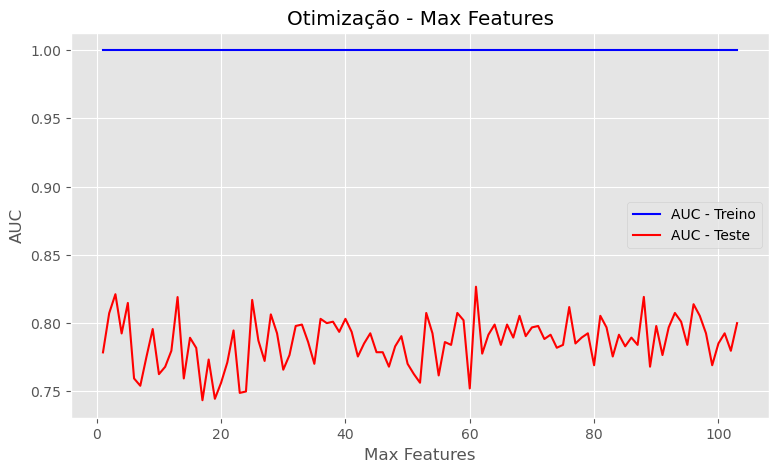

In [12]:
plt.figure(figsize = (9,5))
line1, = plt.plot(max_features, train_results, "b", label= "AUC - Treino")
line2, = plt.plot(max_features, test_results, "r", label = "AUC - Teste")
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel("AUC")
plt.xlabel("Max Features")
plt.legend()
plt.title("Otimização - Max Features")
plt.show()

In [13]:
arvores = [1, 10, 50, 100, 150, 200, 250, 500, 1000, 1500]
max_depths = np.linspace(15, 40, 26, endpoint = True)
train_results = []
test_results = []
parameters = pd.DataFrame(columns = ["arvores", "max_depths", "train_roc", "test_roc"])

for arvore in arvores:
    for max_depth in max_depths:
        print(arvore, "/",max_depth, "/ ", end =" ")
        rf = RandomForestClassifier(bootstrap = True,
               criterion = 'gini', max_depth = max_depth, max_features = "auto",
               min_samples_leaf = 1, min_samples_split = 2,
               n_estimators = arvore, n_jobs = 7, oob_score = True, random_state = 42);
        rf.fit(X_train_norm, y_train)
        train_pred = rf.predict(X_train_norm)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc_train = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc_train)
        y_pred = rf.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc_test = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc_test)
        parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
                                                    , columns = parameters.columns))


1 / 15.0 /  1 / 16.0 /  1 / 17.0 /  1 / 18.0 /  1 / 19.0 /  1 / 20.0 /  1 / 21.0 /  1 / 22.0 /  1 / 23.0 /  1 / 24.0 /  1 / 25.0 /  1 / 26.0 /  1 / 27.0 /  1 / 28.0 /  1 / 29.0 /  1 / 30.0 /  1 / 31.0 /  1 / 32.0 /  1 / 33.0 /  1 / 34.0 /  1 / 35.0 /  1 / 36.0 /  1 / 37.0 /  1 / 38.0 /  1 / 39.0 /  1 / 40.0 /  10 / 15.0 /  10 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has featu

10 / 17.0 /  10 / 18.0 /  10 / 19.0 /  10 / 20.0 /  10 / 21.0 /  10 / 22.0 /  10 / 23.0 /  10 / 24.0 /  10 / 25.0 /  10 / 26.0 /  10 / 27.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

10 / 28.0 /  10 / 29.0 /  10 / 30.0 /  10 / 31.0 /  10 / 32.0 /  10 / 33.0 /  10 / 34.0 /  10 / 35.0 /  10 / 36.0 /  10 / 37.0 /  10 / 38.0 /  10 / 39.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

10 / 40.0 /  50 / 15.0 /  50 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

50 / 17.0 /  50 / 18.0 /  50 / 19.0 /  50 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

50 / 21.0 /  50 / 22.0 /  50 / 23.0 /  50 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

50 / 25.0 /  50 / 26.0 /  50 / 27.0 /  50 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

50 / 29.0 /  50 / 30.0 /  50 / 31.0 /  50 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

50 / 33.0 /  50 / 34.0 /  50 / 35.0 /  50 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

50 / 37.0 /  50 / 38.0 /  50 / 39.0 /  50 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has fe

100 / 15.0 /  100 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 17.0 /  100 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 19.0 /  100 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 21.0 /  100 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 23.0 /  100 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 25.0 /  100 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 27.0 /  100 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 29.0 /  100 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 31.0 /  100 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 33.0 /  100 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 35.0 /  100 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 37.0 /  100 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


100 / 39.0 /  100 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 15.0 /  150 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 17.0 /  150 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 19.0 /  150 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 21.0 /  150 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 23.0 /  150 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 25.0 /  150 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 27.0 /  150 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 29.0 /  150 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 31.0 /  150 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 33.0 /  150 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 35.0 /  150 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 37.0 /  150 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


150 / 39.0 /  150 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]
/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 15.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 17.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 19.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 21.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 23.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 25.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 27.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 29.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 31.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 33.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 35.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 37.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 39.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


200 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 15.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 17.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 19.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 21.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 23.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 25.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 27.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 29.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 31.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 33.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 35.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 37.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 39.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


250 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 15.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 17.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 19.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 21.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 23.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 25.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 27.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 29.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 31.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 33.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 35.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 37.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 39.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


500 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 15.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 17.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 19.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 21.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 23.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 25.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 27.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 29.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 31.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 33.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 35.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 37.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 39.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1000 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 15.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 16.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 17.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 18.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 19.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 20.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 21.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 22.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 23.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 24.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 25.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 26.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 27.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 28.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 29.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 30.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 31.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 32.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 33.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 34.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 35.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 36.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 37.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 38.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 39.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


1500 / 40.0 /  

/home/eduardo/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/tmp/ipykernel_19466/3519440201.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameters = parameters.append(pd.DataFrame([[arvore, max_depth, roc_auc_train, roc_auc_test]]


/tmp/ipykernel_19466/1229001880.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = "3d")


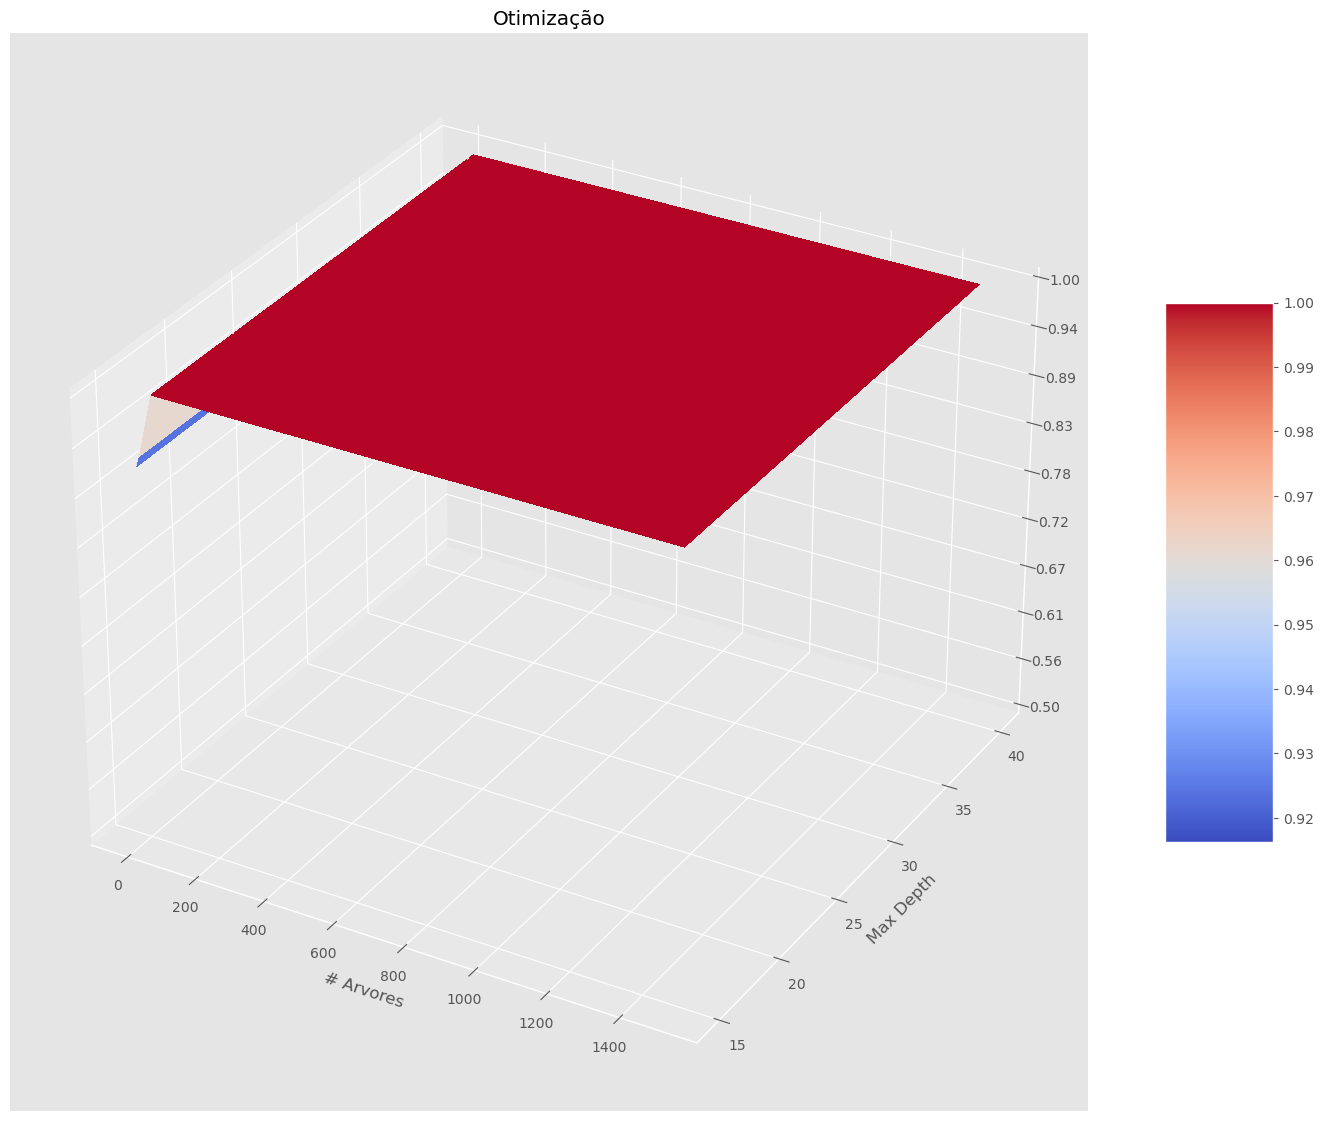

In [14]:
fig = plt.figure(figsize = (20, 14))
ax = fig.gca(projection = "3d")

X = pd.to_numeric(parameters["arvores"])
Y = pd.to_numeric(parameters["max_depths"])
Z = pd.to_numeric(parameters["train_roc"])
X, Y = np.meshgrid(X, Y)
Z = np.meshgrid(Z,Z)[0]

surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm,
                       linewidth = 0, antialiased = False)

ax.set_zlim(0.5, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))

fig.colorbar(surf, shrink = 0.5, aspect = 5)


plt.xlabel("# Arvores")
plt.ylabel("Max Depth")
plt.title("Otimização")

plt.show()